In [1]:
import pandas as pd
from pathlib import Path
import inspect 
import numpy as np
import datetime
import os
import json
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from dotmap import DotMap
import torch
import torch.nn.init as init
import torch.nn as nn
import pickle
import seaborn as sns
sns.set_theme(style="white", rc={"axes.grid": False})


In [12]:
data = pd.read_parquet("pivae_paper/data_manipulation/final_night_data.parquet")


In [13]:
def set_season_tag(df, isnorth = True):
    if isnorth:
        df["season"] = (df['DateTime'].dt.month%12 + 3) // 3 # print(seasons)
    else:
        df["season"] = ((df['DateTime'].dt.month + 6)%12 + 3)//3
    return df, "season"

def extract_time_features(df):
    """
    Extract features from the timestamp for model training.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    
    Returns:
    pd.DataFrame: DataFrame with extracted features, list: features added to dataframe
    """
    df = df.copy()
    df['hour'] = df['DateTime'].dt.hour
    df['dayofweek'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['dayofyear'] = df['DateTime'].dt.dayofyear
    return df, ["hour", "dayofweek", "month", "dayofyear"]

def split_data_years(df, train_years, test_years, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    train_years (int): Years to include in training data
    test_years (int): Years to include in test data
    
    Returns:
    tuple: Training and test DataFrames.
    """
    
    train_data = df[df.apply(lambda x: x['DateTime'].year in train_years, axis=1)]
    data = df[df.apply(lambda x: x['DateTime'].year in test_years, axis=1)]
    return train_data.reset_index(drop=True), data.reset_index(drop=True)
    
def split_data(df, train_year_thresh, test_year_thresh=2018, test_size=0.2):
    """
    Split data into training and test sets.
    
    Parameters:
    data (pd.DataFrame): DataFrame with 'Timestamp' and 'NEE' columns.
    train_year_thresh (int): Year till which to include in training data (inclusive)
    test_year_thresh (int): Year till which to include in test data (inclusive)
    
    Returns:
    tuple: Training and test DataFrames.
    """
    assert train_year_thresh <= test_year_thresh, "train_year_thresh has to be less than test_year_thresh"
    train_data = df[df.DateTime.dt.year <= train_year_thresh]
    data = df[df.DateTime.dt.year >= test_year_thresh]
    return train_data.reset_index(drop=True), data.reset_index(drop=True)

In [14]:
data['year'] = data.DateTime.dt.year

In [15]:
data, season_feat = set_season_tag(data)
data, time_feat = extract_time_features(data)

In [18]:
drivers = np.array(['Ta', 'H', 'Pa', 'Tau', 'LE', 'CO2_strg', 'H_strg', 'LE_strg', 'RH', 'VPD', 'Rg', 'Rnet', 'Ustar', 
                    'Tsoil1', 'Tsoil2', 'VWC_1',
       'VWC2', 'Precipitation', 'Windspeed', 'Winddir', 'FootprintFraction', 'L', 'zL', 'TER', 'GEP'])
data = data[data["dNEE"].notna()].reset_index(drop=True)
columns_to_check_na = np.concatenate([drivers, ["NEE", "dTa"]])

idx = (np.sum(data[columns_to_check_na].notna(), axis=1) == columns_to_check_na.shape[0])
data = data.loc[idx].reset_index(drop=True)

In [19]:
def physics_nee(k, T, Tref=10, T0=46.02):
    e0 = k[:, 0]
    rb = k[:, 1]
    exp_term = np.exp(e0 * (1.0 / (Tref - T0) - 1.0 / (T - T0)))
    NEE = rb * exp_term
    return NEE

In [20]:
data["NEE_phy"] = physics_nee(data[["E0", "rb"]].values, data.Ta.values)

In [21]:
plt.plot("")

0        5.14360
1        5.29860
2        4.73990
3        6.23570
4        6.07240
          ...   
18387    1.10410
18388    1.15650
18389    0.94792
18390    1.22880
18391    0.55406
Name: NEE, Length: 18392, dtype: float64

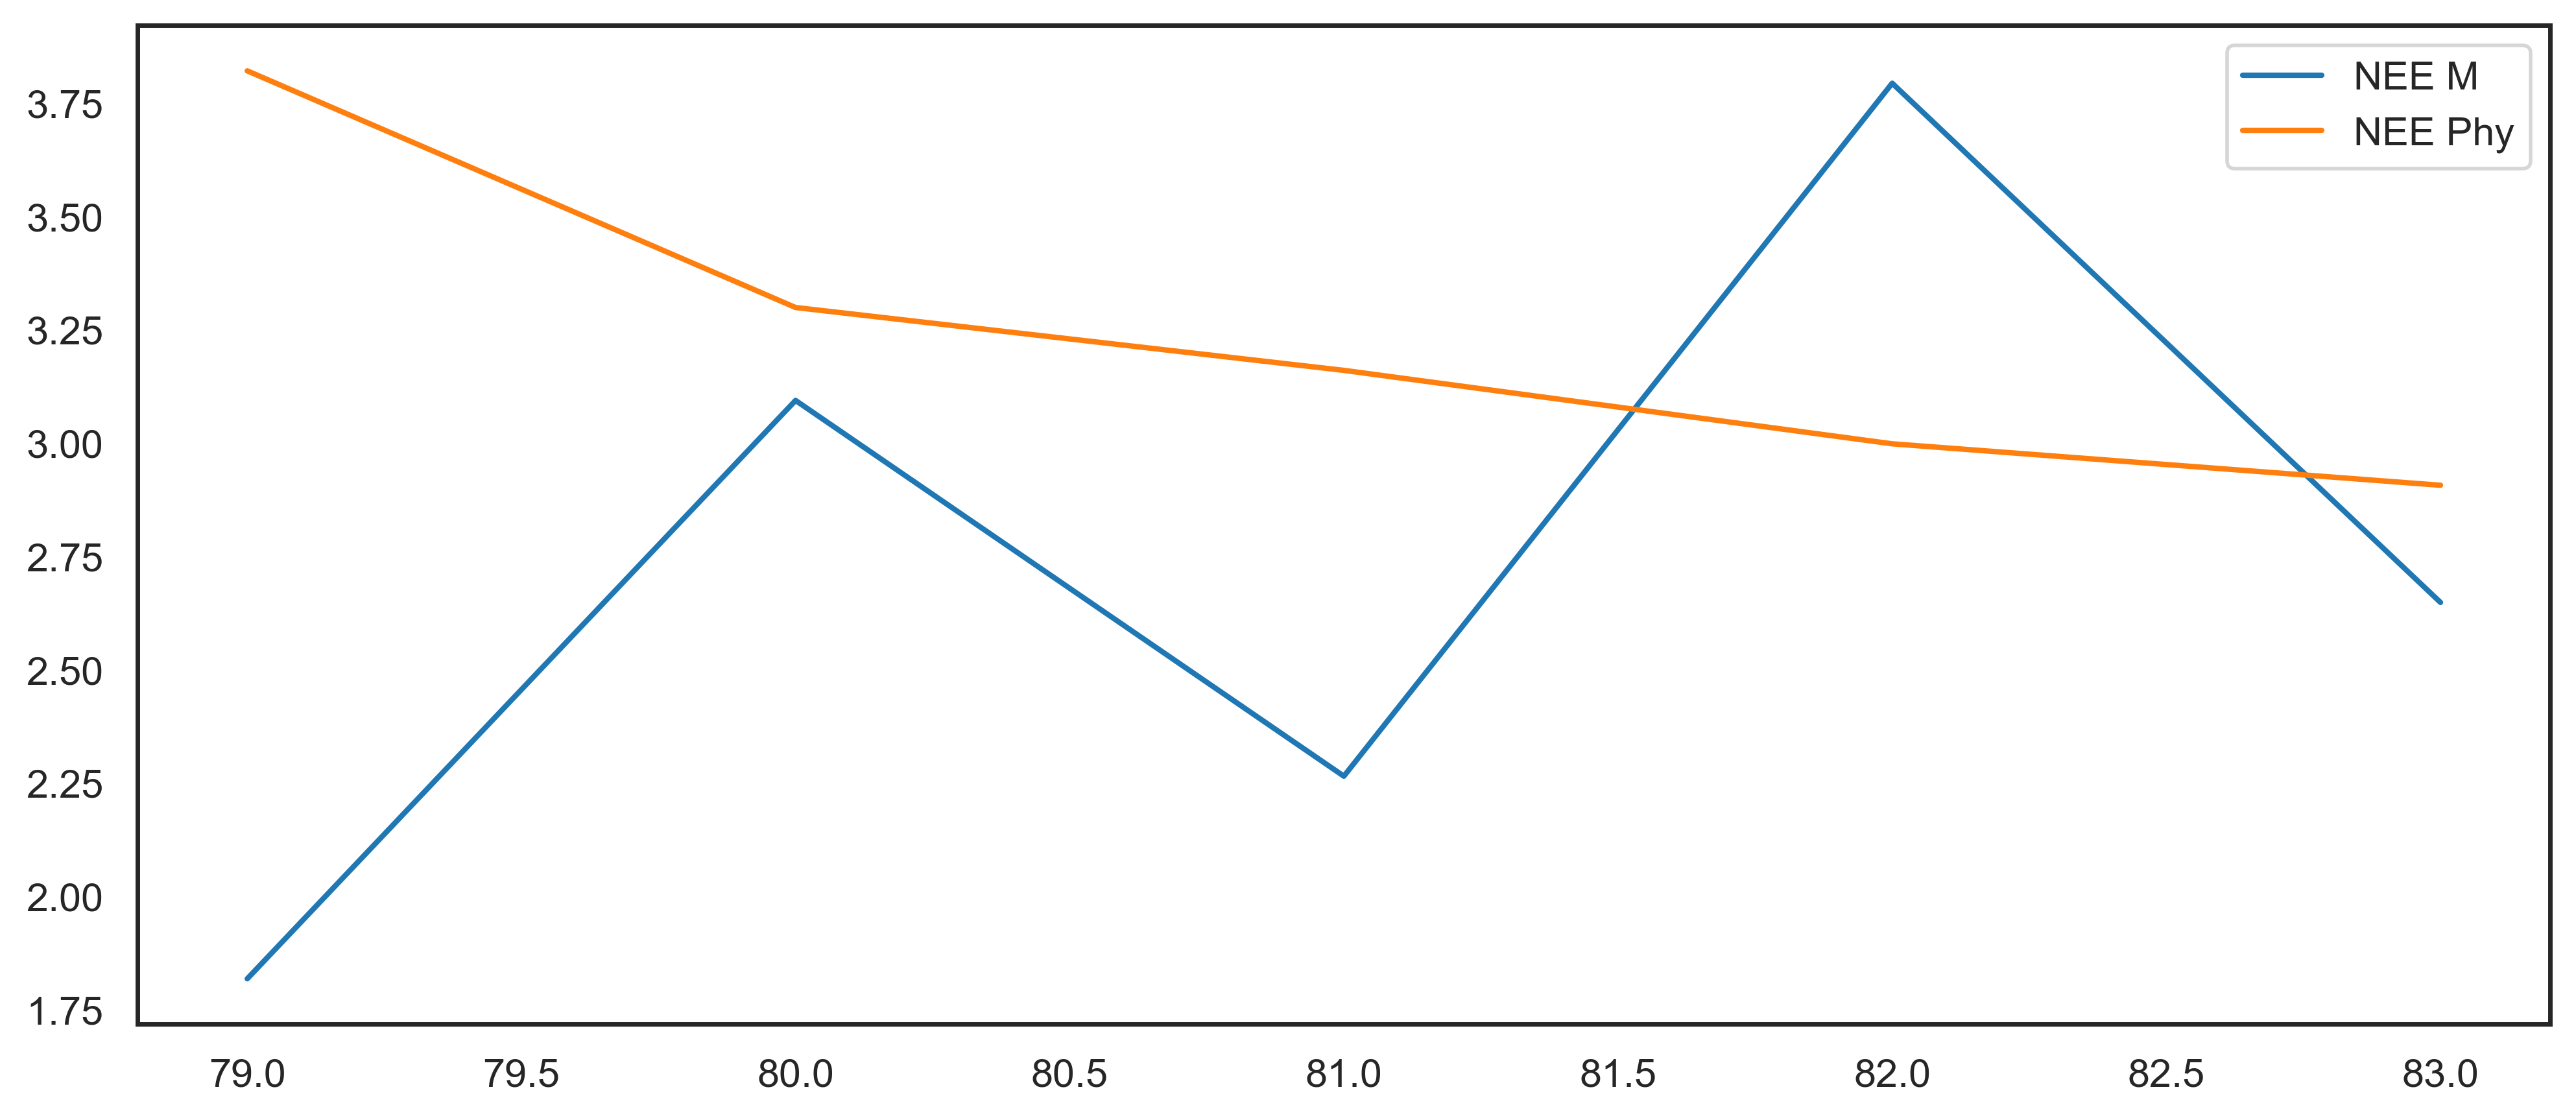

In [26]:
### Daily

data['time_diff'] = data.DateTime.diff()

data['daily_group'] = (data.time_diff > pd.Timedelta(hours=2)).cumsum()

mask = (data['daily_group'] == 16).values

date = data.DateTime[mask].iloc[0]
date = str(date).split(' ')[0]

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(data.NEE[mask], color="#1f77b4")
ax.plot(data.NEE_phy[mask], color="#ff7f0e")
ax.legend(["NEE M", "NEE Phy"])



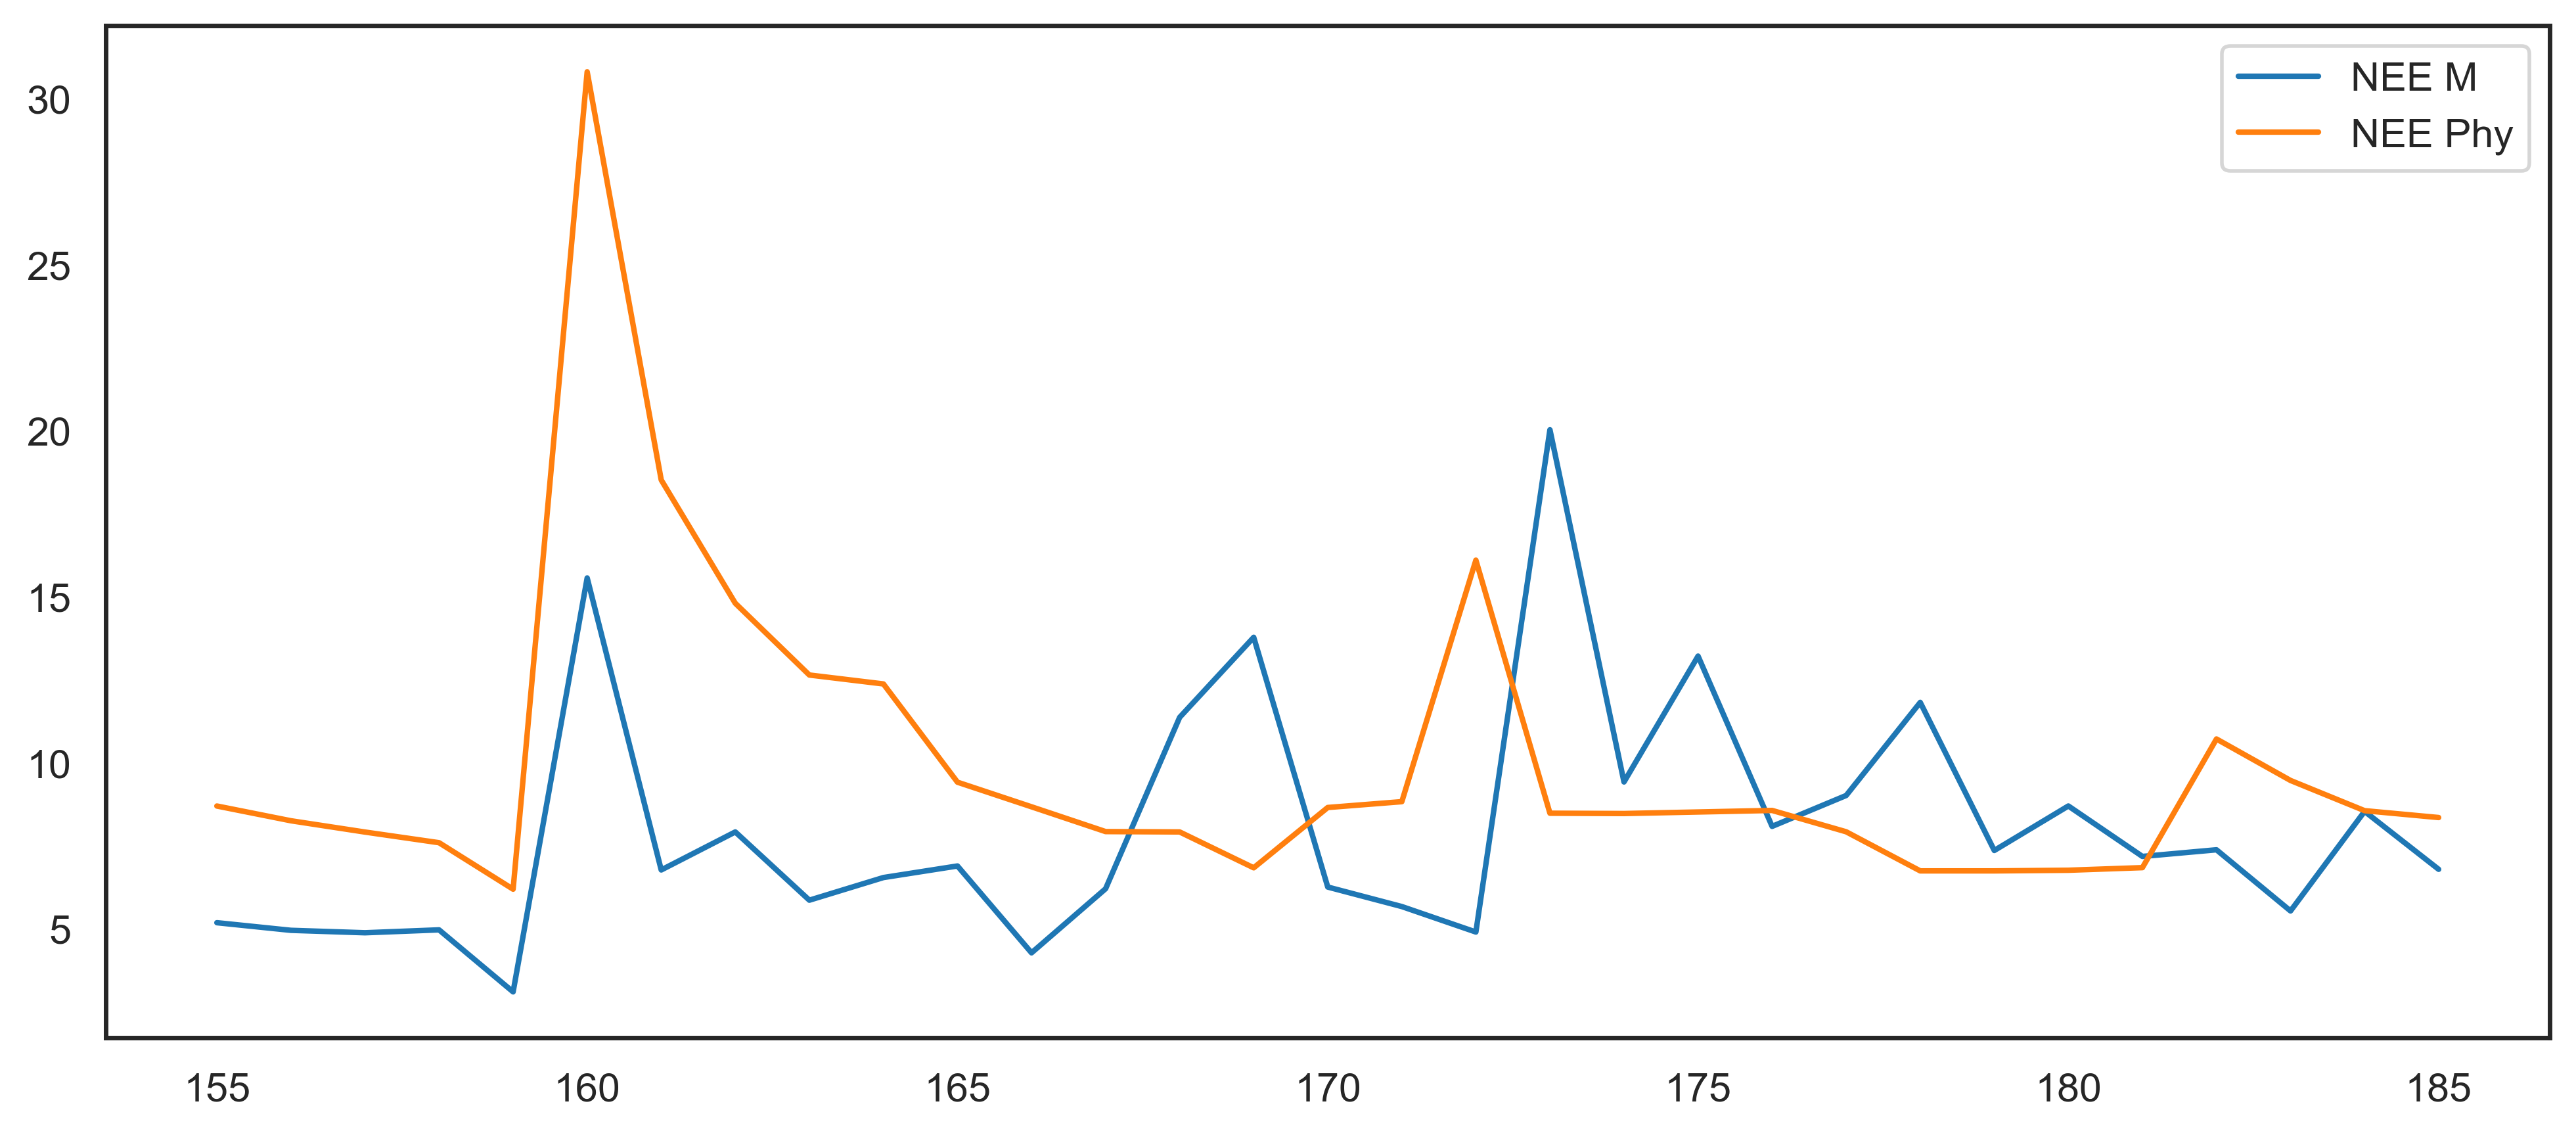

In [27]:
### Weekly

data['week_group'] = (data['dayofweek'] < data['dayofweek'].shift()).cumsum()

mask = data.week_group == 4

date1 = data.DateTime[mask].iloc[0]
date2 = data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(data.NEE[mask], color="#1f77b4")
ax.plot(data.NEE_phy[mask], color="#ff7f0e")
ax.legend(["NEE M", "NEE Phy"])



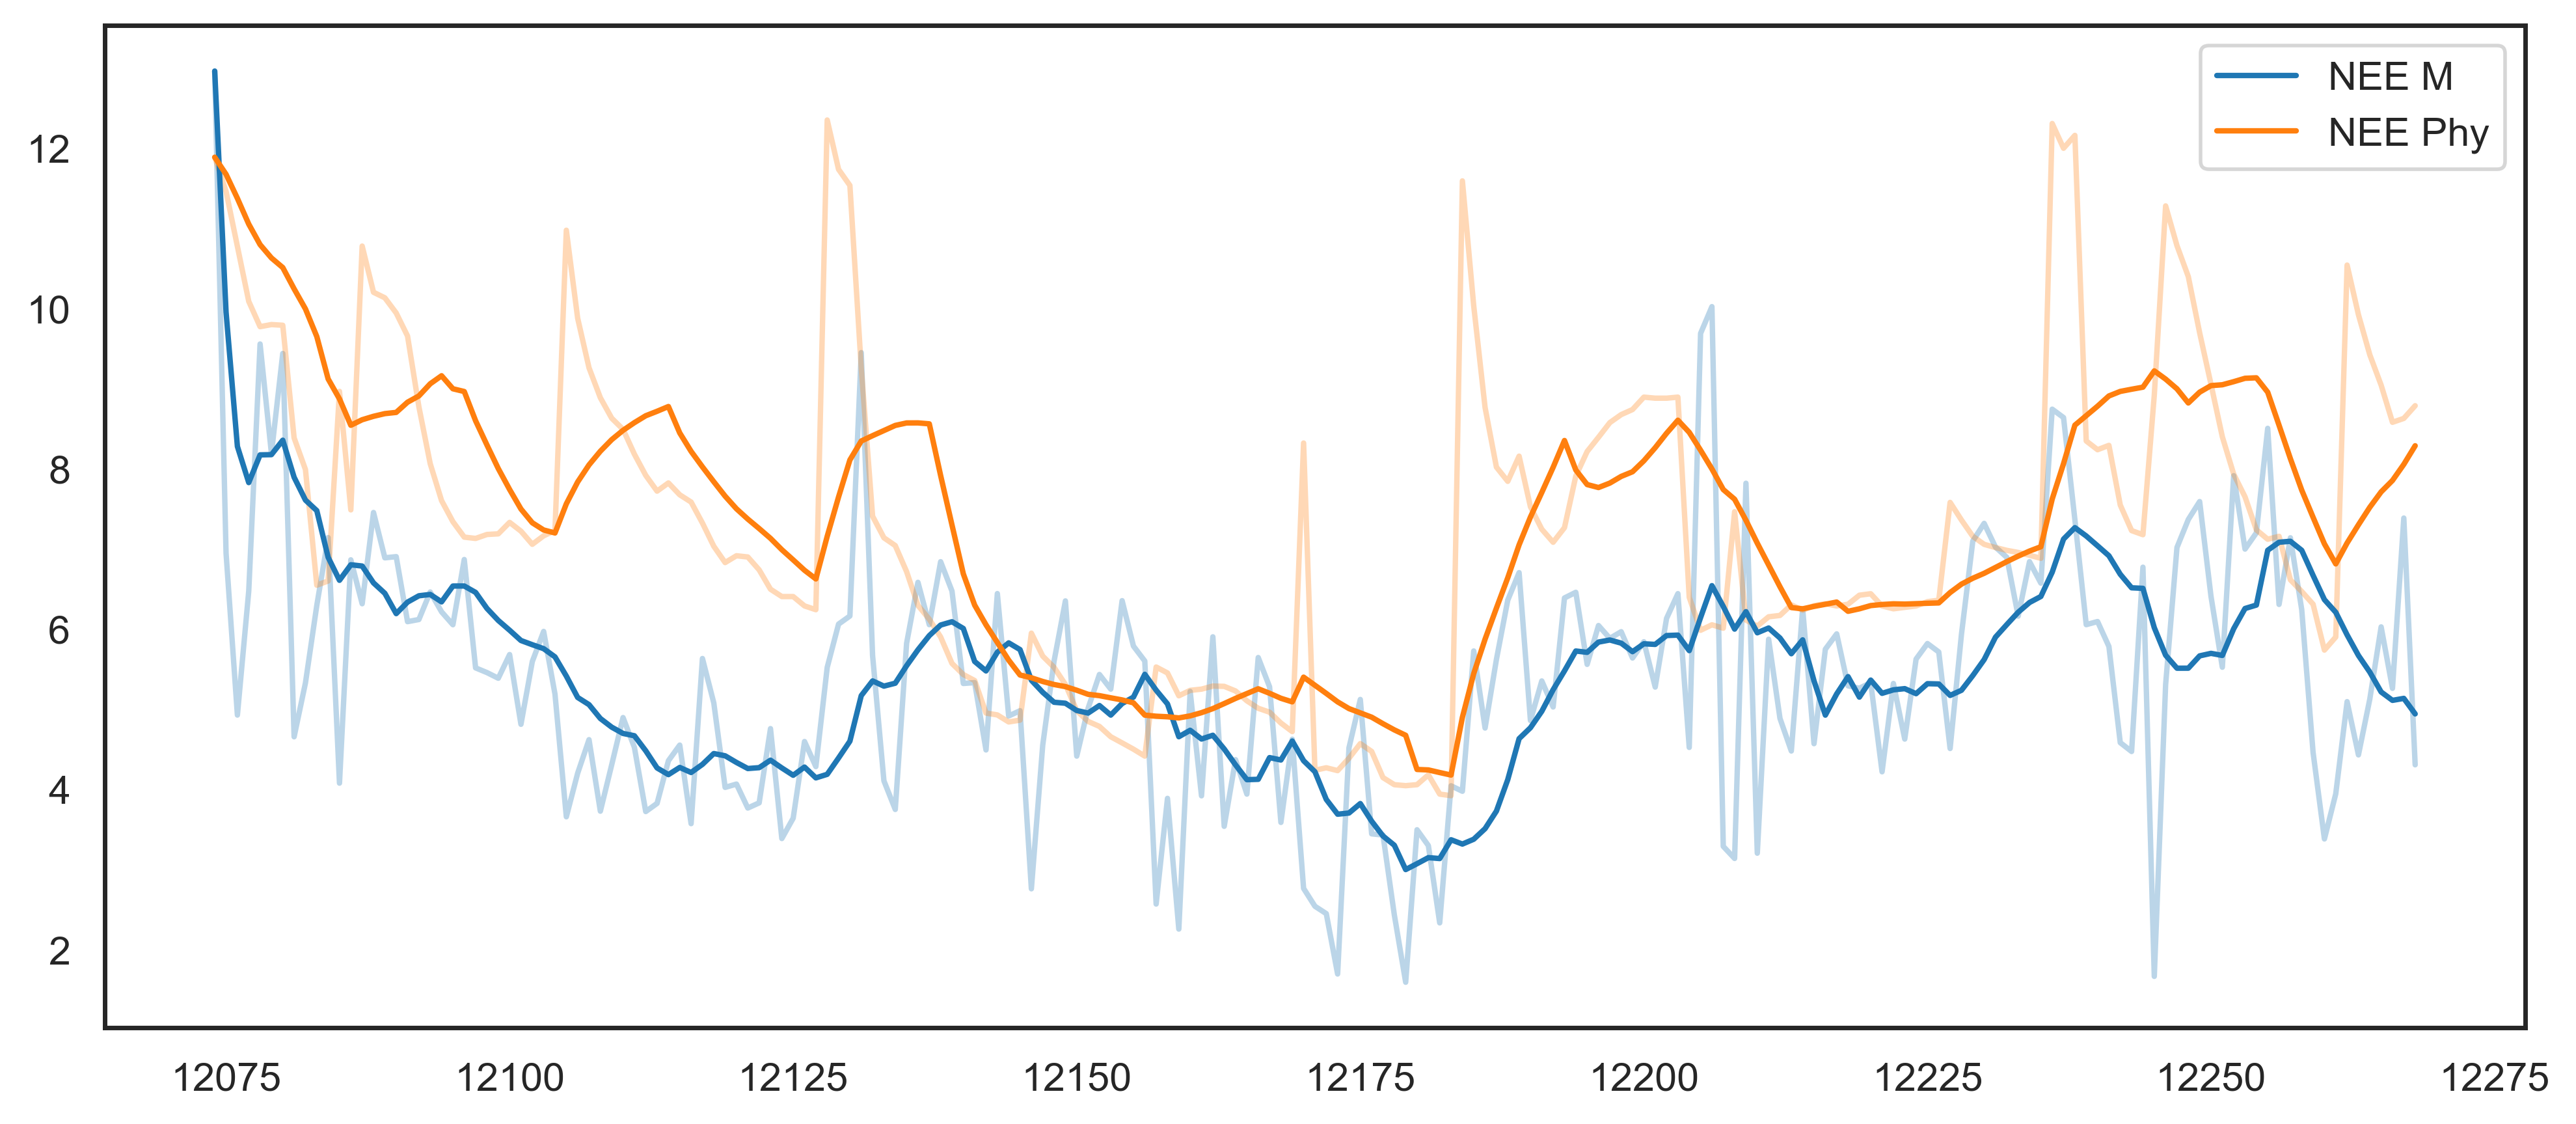

In [32]:
### Monthly

mask = (data.DateTime.dt.year == 2017) & (data.DateTime.dt.month == 9)

date1 = data.DateTime[mask].iloc[0]
date2 = data.DateTime[mask].iloc[-1]
date = str(date1).split(' ')[0] + " till " + str(date2).split(' ')[0]

gt_vis = data.NEE[mask]
preds_vis = data.NEE_phy[mask]

window_size = 10



gt_vis_smoothed = pd.Series(gt_vis).rolling(window=window_size, min_periods=1).mean()
preds_vis_smoothed = pd.Series(preds_vis).rolling(window=window_size, min_periods=1).mean()

fig, ax = plt.subplots(figsize=(12, 5), dpi=400)
ax.plot(gt_vis, alpha=0.3, color="#1f77b4")
ax.plot(preds_vis, alpha=0.3, color="#ff7f0e")
ax.plot(gt_vis_smoothed, color="#1f77b4", label="NEE M")
ax.plot(preds_vis_smoothed, color="#ff7f0e", label="NEE Phy")
ax.legend()